# Deploy to Endpoint

In [11]:
import boto3
import sagemaker
import time
from time import strftime

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)
sm_client = boto3.client("sagemaker")
region = boto_session.region_name
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
account = sagemaker_session.boto_session.client("sts").get_caller_identity()["Account"]


print(f"account: {account}")
print(f"bucket: {bucket}")
print(f"region: {region}")
print(f"role: {role}")

account: 294495367161
bucket: sagemaker-ap-south-1-294495367161
region: ap-south-1
role: arn:aws:iam::294495367161:role/service-role/AmazonSageMaker-ExecutionRole-20221204T133204


In [4]:
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

Get the `model_data` from the models uploaded to S3 of the aboved training

Once your debugging is done, it's better to simply call `pt_estimator.deploy`

In [37]:
model = PyTorchModel(
    entry_point="infer.py",
    source_dir="/root/emlov2-session-12/",
    role=get_execution_role(),
    model_data="s3://sagemaker-ap-south-1-294495367161/training-intel-dataset-2022-12-10-11-50-46-168/output/model.tar.gz",
    framework_version="1.12.0",
    py_version="py38",
)

In [38]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

--------!

## Predictor

In [54]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from sagemaker.pytorch import PyTorchPredictor

Predictor is also not needed to be created again, but today we want to be verbose

In [39]:
predictor_new = PyTorchPredictor(
    endpoint_name="pytorch-inference-2022-12-10-14-14-43-839",
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

In [59]:
def predict(source):
    if "http" in source:
        # !wget -O image.jpg $source
        response = requests.get(source)
        im = Image.open(BytesIO(response.content))

        # im = Image.open("image.jpg").convert('RGB')
    else:
        im = Image.open(source).convert("RGB")

    inputs = {"inputs": np.array(im)}

    out = predictor_new.predict(inputs)
    print(out)
    im.show()

{'forest': 1.0, 'glacier': 6.388662873013999e-18, 'street': 9.86878789949506e-19, 'buildings': 5.253123700364345e-19, 'mountain': 5.796448109184881e-20}


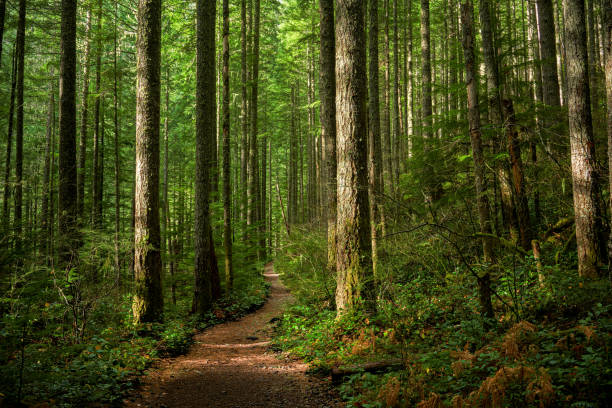

In [60]:
predict(
    "https://media.istockphoto.com/id/1205214235/photo/path-through-sunlit-forest.jpg?s=612x612&w=0&k=20&c=-AS1aTz85kcZ2X7E8n2iFlm6dsdIMyWGWrSDQ1o-f_0="
)

{'forest': 1.0, 'glacier': 1.9711017841935125e-15, 'mountain': 7.244335308176109e-17, 'street': 6.637256289685173e-18, 'buildings': 9.375428430846995e-19}


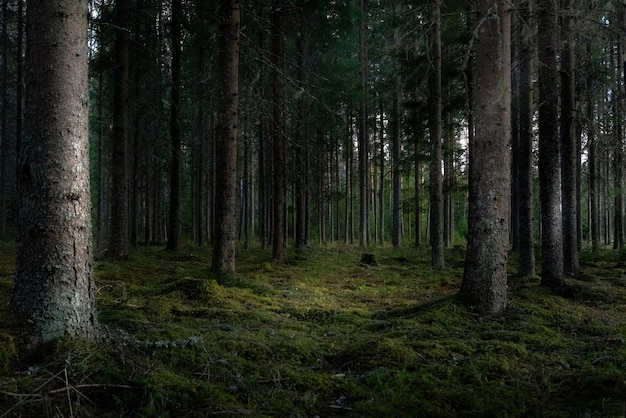

In [62]:
predict(
    "https://img.freepik.com/free-photo/beautiful-shot-forest-with-tall-green-trees_181624-20615.jpg"
)

{'glacier': 1.0, 'mountain': 3.477873544710519e-09, 'sea': 2.1629233959430394e-09, 'street': 1.8601260809436582e-10, 'forest': 1.4277840021392763e-10}


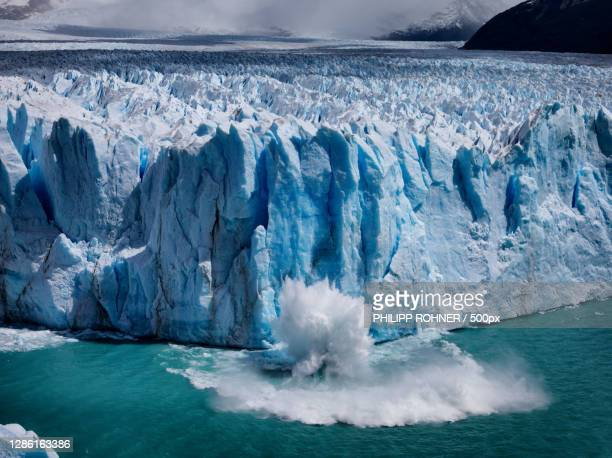

In [64]:
predict(
    "https://media.gettyimages.com/id/1286163386/photo/scenic-view-of-frozen-sea-against-sky.jpg?s=612x612&w=gi&k=20&c=nNBO1_HhXO6e83KLCzGjKI3SthhyIhdb0DN9E6ejt2k="
)

In [3]:
! pip install --quiet timm pytorch-lightning


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


{'glacier': 0.9985077977180481, 'sea': 0.0011400897055864334, 'mountain': 0.0003472748794592917, 'buildings': 2.1594830741378246e-06, 'forest': 2.108237595166429e-06}


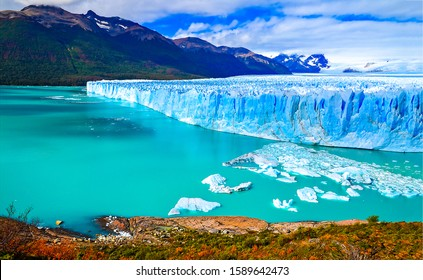

In [65]:
predict(
    "https://www.shutterstock.com/image-photo/perito-moreno-glacier-patagonia-argentina-260nw-1589642473.jpg"
)

{'mountain': 0.9984560012817383, 'glacier': 0.001543929218314588, 'forest': 5.605555841725618e-08, 'buildings': 3.5306221946029837e-08, 'sea': 1.0593351085219638e-08}


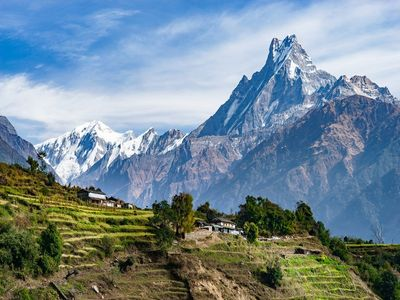

In [73]:
predict("https://imgk.timesnownews.com/story/mountain-stock.jpg?tr=w-400,h-300,fo-auto")

{'mountain': 0.9803871512413025, 'buildings': 0.007262371946126223, 'glacier': 0.0054288930259644985, 'forest': 0.004233497194945812, 'sea': 0.002587634604424238}


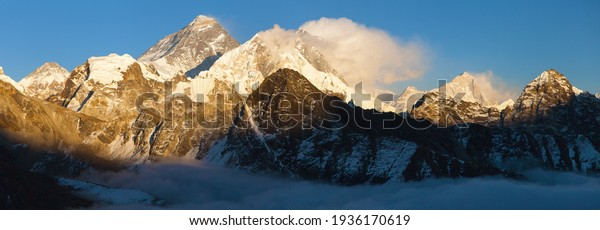

In [75]:
predict(
    "https://www.shutterstock.com/image-photo/evening-sunset-view-mount-everest-600w-1936170619.jpg"
)

In [36]:
from typing import Any, Dict, Optional, Tuple

import os
import subprocess
import torch
import timm

import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn.functional as F

from pathlib import Path
from torchvision.datasets import ImageFolder
from pytorch_lightning.plugins.environments import LightningEnvironment
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy

{'mountain': 0.8534014225006104, 'glacier': 0.13094937801361084, 'sea': 0.00752756092697382, 'buildings': 0.005000389646738768, 'forest': 0.002768037375062704}


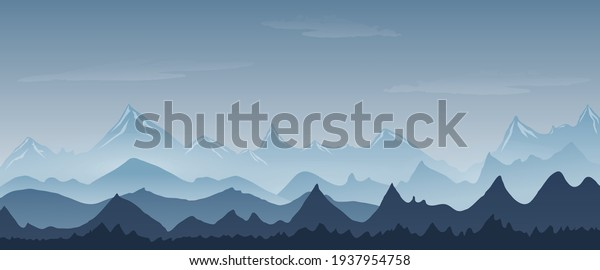

In [76]:
predict(
    "https://www.shutterstock.com/image-vector/blue-mountain-landscape-fog-background-600w-1937954758.jpg"
)

{'sea': 0.9997194409370422, 'glacier': 0.00027973108808510005, 'forest': 4.363378423022368e-07, 'mountain': 2.2159284185363504e-07, 'buildings': 1.5650353191176691e-07}


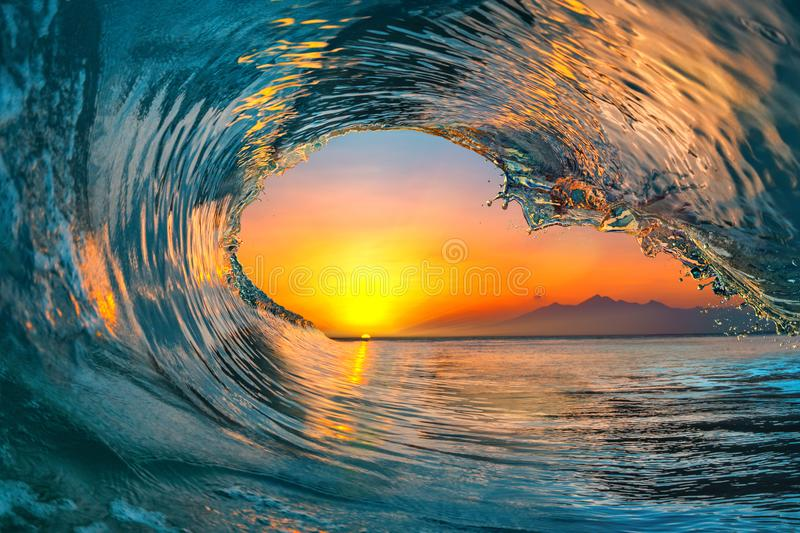

In [78]:
predict(
    "https://thumbs.dreamstime.com/b/sea-water-ocean-wave-surfing-surface-colorful-vibrant-sunset-barrel-shape-124362369.jpg"
)

{'glacier': 0.5940340757369995, 'mountain': 0.4027601182460785, 'sea': 0.0031002953182905912, 'forest': 8.661040192237124e-05, 'buildings': 1.8543038095231168e-05}


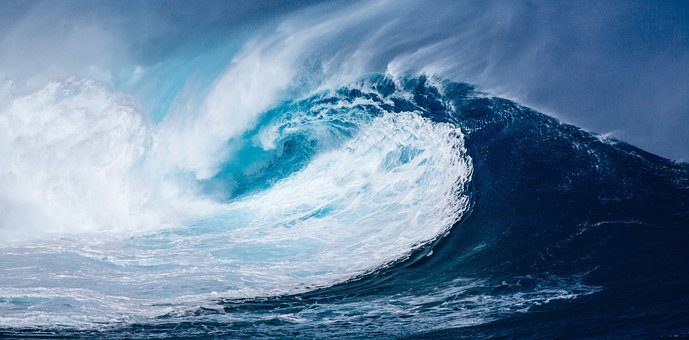

In [79]:
predict("https://cdn.pixabay.com/photo/2016/12/17/14/33/wave-1913559__340.jpg")

{'sea': 0.8809617161750793, 'buildings': 0.10551244765520096, 'forest': 0.009275461547076702, 'glacier': 0.0023050662130117416, 'mountain': 0.0019027364905923605}


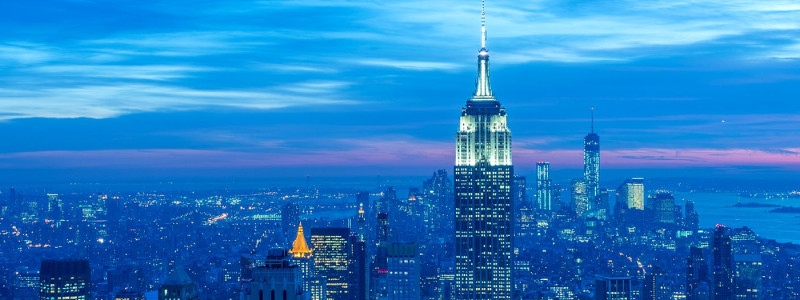

In [83]:
predict(
    "https://images.ctfassets.net/hrltx12pl8hq/3TDofoEgZPCt3qpncet5bm/0a2f0a3858b94f64dc5d5a8bfd07056d/compressed_shutterstock_626223680.jpg?fit=fill&w=800&h=300"
)

{'buildings': 1.0, 'sea': 3.581390739526569e-11, 'street': 2.6270421601970462e-11, 'forest': 1.3039028190497959e-11, 'glacier': 6.992992881808824e-14}


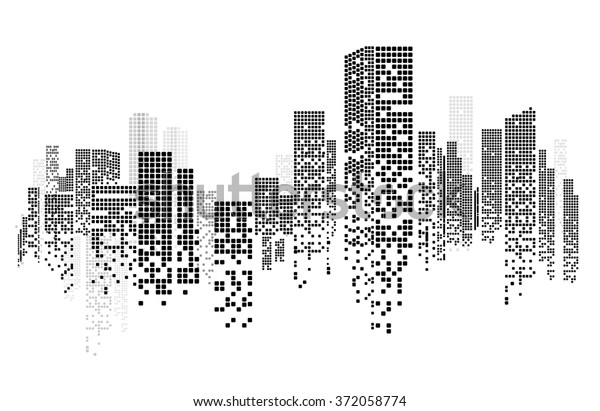

In [88]:
predict(
    "https://www.shutterstock.com/image-vector/building-city-illustration-scene-on-600w-372058774.jpg"
)

{'street': 0.801752507686615, 'buildings': 0.17635375261306763, 'sea': 0.014742350205779076, 'glacier': 0.006137855816632509, 'mountain': 0.0006561982445418835}


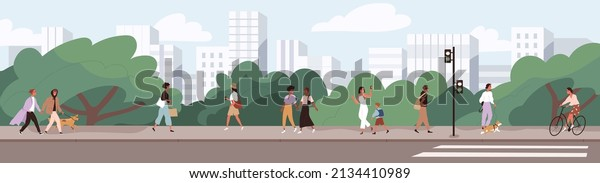

In [90]:
predict(
    "https://www.shutterstock.com/image-vector/people-going-along-city-street-600w-2134410989.jpg"
)

{'street': 1.0, 'buildings': 5.78061210010361e-10, 'mountain': 6.554618501609932e-13, 'glacier': 3.0794797593013123e-13, 'sea': 1.118272412604232e-13}


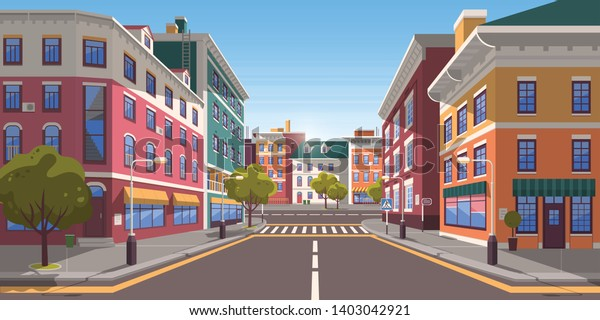

In [91]:
predict(
    "https://www.shutterstock.com/image-vector/street-town-vector-city-path-600w-1403042921.jpg"
)

In [37]:
class LitResnet(pl.LightningModule):
    def __init__(self, num_classes=10, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = timm.create_model("resnet18", pretrained=True)

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}/loss", loss, prog_bar=True)
            self.log(f"{stage}/acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        return {"optimizer": optimizer}

In [38]:
class FlowerDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "data/",
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        self.data_dir = Path(data_dir)

        # data transformations
        self.transforms = T.Compose(
            [
                T.ToTensor(),
                T.Resize((224, 224)),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

        self.data_train: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

    @property
    def num_classes(self):
        return len(self.data_train.classes)

    @property
    def classes(self):
        return self.data_train.classes

    def prepare_data(self):
        """Download data if needed.
        Do not use it to assign state (self.x = y).
        """
        pass

    def setup(self, stage: Optional[str] = None):
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.
        This method is called by lightning with both `trainer.fit()` and `trainer.test()`, so be
        careful not to execute things like random split twice!
        """
        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_test:
            trainset = ImageFolder(self.data_dir / "train", transform=self.transforms)
            testset = ImageFolder(self.data_dir / "test", transform=self.transforms)

            self.data_train, self.data_test = trainset, testset

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass

In [39]:
datamodule = FlowerDataModule(
    data_dir=(Path("/root/flower-project/example-git/") / "dataset").absolute()
)
datamodule.setup()

In [40]:
datamodule.num_classes

5

In [41]:
model = LitResnet(num_classes=datamodule.num_classes)

INFO:timm.models.helpers:Loading pretrained weights from url (https://download.pytorch.org/models/resnet18-5c106cde.pth)


In [42]:
trainer = pl.Trainer(
    max_epochs=2,
    accelerator="auto",
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
trainer.fit(model, datamodule)


  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.7 M
---------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)


Epoch 0:   3%|▎         | 3/102 [00:32<18:06, 10.97s/it, loss=5.55, v_num=4]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
